In [1]:
import h5py
from tqdm import tqdm
import itertools
import numpy as np

import scipy.spatial
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import math

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=4)

ATOMIC_NUMBERS = [1, 6, 7, 8]
N_KNOTS = 10
CUTOFFS = {
    (1, 1): (0.67900, 1.20000),
    (1, 6): (0.68953, 1.52770),
    (1, 7): (0.65268, 1.53994),
    (1, 8): (0.67939, 1.46027),
    (6, 6): (1.13182, 1.77828),
    (6, 7): (1.02777, 1.76680),
    (6, 8): (1.08495, 1.79859),
    (7, 7): (1.07612, 1.82450),
    (7, 8): (1.10998, 1.84896),
    (8, 8): (1.16000, 1.50000),
}


ATOMIC_PAIRS = [tuple(sorted(x)) for x in itertools.combinations_with_replacement(ATOMIC_NUMBERS, 2)]
KNOTS = {(i, j): np.linspace(*CUTOFFS[(i, j)], N_KNOTS) for i, j in ATOMIC_PAIRS}

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
def load_h5_dataset(path, n_formulas=None, max_heavy=None, show_progress=True):
    dframes = []

    def get_n_heavy(item):
        return (np.array(item["atomic_numbers"]) > 1).sum()

    with h5py.File(path, "r") as f:
        iterator = filter(lambda x: get_n_heavy(x[1]) <= max_heavy, f.items())
        iterator = itertools.islice(iterator, n_formulas)

        if show_progress:
            iterator = tqdm(iterator, total=n_formulas)

        for empirical_formula, entry in iterator:
            coordinates = list([np.asarray(c) for c in entry["coordinates"]])
            atomic_numbers = list(entry["atomic_numbers"])
            dframes.append(
                pd.DataFrame(
                    {
                        "mol": np.array([empirical_formula] * len(coordinates), dtype=str),
                        "iconf": np.array(list(range(len(coordinates))), dtype=np.int32),
                        "atomic_numbers": [atomic_numbers] * len(coordinates),
                        "coordinates": coordinates,
                    },
                )
            )

    df = pd.concat(dframes).reset_index(drop=True)

    df["mol"] = df["mol"].astype("category")
    return df

In [3]:
df = load_h5_dataset("../data/raw/ANI-1ccx_clean_fullentry.h5", n_formulas=None, max_heavy=8)


471it [00:01, 358.93it/s]


In [4]:
df.head()

,mol,iconf,atomic_numbers,coordinates
0,C1H1N1,0,"[6, 1, 7]","[[0.014473461, 0.49763787, -5.881349e-17], [-0..."
1,C1H1N1,1,"[6, 1, 7]","[[0.0057673096, 0.4938686, -7.505203e-17], [-0..."
2,C1H1N1,2,"[6, 1, 7]","[[0.028821878, 0.51213276, 5.788162e-19], [-0...."
3,C1H1N1,3,"[6, 1, 7]","[[0.02539955, 0.5248015, -7.0745275e-18], [-0...."
4,C1H1N1,4,"[6, 1, 7]","[[0.020802982, 0.47589356, 4.2541737e-17], [-0..."


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232310 entries, 0 to 232309
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   mol             232310 non-null  category
 1   iconf           232310 non-null  int32   
 2   atomic_numbers  232310 non-null  object  
 3   coordinates     232310 non-null  object  
dtypes: category(1), int32(1), object(2)
memory usage: 4.9+ MB


In [6]:
def combination_sorted(x, r):
    return [tuple(sorted(p)) for p in itertools.combinations(x, r)]


In [7]:
df["pairs"] = df["atomic_numbers"].apply(lambda x: combination_sorted(x, 2))

In [8]:
df["pdist"] = df["coordinates"].apply(scipy.spatial.distance.pdist)

In [9]:
def atomic_value_counts(atomic_numbers, known_values):
    counts = np.array([atomic_numbers.count(v) for v in known_values])
    return counts

atomic_value_counts([6, 1, 7], [1, 6, 7, 8])

array([1, 1, 1, 0])

In [10]:
def group_pairwise_distances(pdists, pairs, known_pairs):
    groups = [[] for _ in known_pairs]
    for pdist, pair in zip(pdists, pairs):
        idx = known_pairs.index(pair)
        groups[idx].append(pdist)

    groups = [np.array(g, dtype=np.float32) for g in groups]
    return groups

grouped_pdist_cols = [f"r_{a1}_{a2}" for a1, a2 in ATOMIC_PAIRS]
df[grouped_pdist_cols] = df.parallel_apply(
    lambda x: group_pairwise_distances(x["pdist"], x["pairs"], ATOMIC_PAIRS),
    axis=1,
    result_type="expand",
)

In [11]:
atom_count_cols = [f"N_{a}" for a in ATOMIC_NUMBERS]
df[atom_count_cols] = df.parallel_apply(
    lambda x: atomic_value_counts(x["atomic_numbers"], ATOMIC_NUMBERS),
    axis=1,
    result_type="expand",
)

In [12]:
import splines
import importlib
importlib.reload(splines)
from splines import bspline_basis

In [13]:
basis_cols = [f"B({col})" for col in grouped_pdist_cols]

def bspline_bases(rs, knots, degree=3):
    if not rs.size:
        bases = np.zeros((0, N_KNOTS - degree - 1), dtype=np.float32)
    else:
        bases = np.array([bspline_basis(r, degree, knots) for r in rs], dtype=np.float32)

    return bases

for col, knots in zip(grouped_pdist_cols, KNOTS.values()):
    new_col = f"B({col})"
    df[new_col] = df[col].parallel_apply(lambda rs: bspline_bases(rs, knots))

In [14]:
def sum_within_range(bs, rs, rmin, rmax):
    # Use np.ma to sum only the values within the range
    mask = (rs >= rmin) & (rs <= rmax)
    # mask = np.array([mask] * bs.shape[1]).T
    # bs[mask,:] = 0.0
    return np.sum(bs[mask,:], axis=0)

In [15]:
summed_basis_cols = [f"sum({col})" for col in basis_cols]
for col, cutoff in zip(basis_cols, CUTOFFS.values()):
    lo, hi = cutoff
    new_col = f"sum({col})"
    z_i = col.strip("()").split("_")[1]
    z_j = col.strip("()").split("_")[2]
    pdist_col = f"r_{z_i}_{z_j}"
    # df[new_col] = df[col].parallel_apply(lambda bs: np.sum(bs, axis=0))
    df[new_col] = df[[col, pdist_col]].apply(lambda row: sum_within_range(row[0], row[1], lo, hi), axis=1)

In [16]:
def num_within_cutoff(rs, lo, hi):
    return np.sum((rs >= lo) & (rs < hi))

for col, cutoff in zip(grouped_pdist_cols, CUTOFFS.values()):
    new_col = f"N_within_{col}"
    df[new_col] = df[col].parallel_apply(lambda rs: num_within_cutoff(rs, *cutoff))

In [17]:
df

,mol,iconf,atomic_numbers,coordinates,pairs,pdist,r_1_1,r_1_6,r_1_7,r_1_8,...,N_within_r_1_1,N_within_r_1_6,N_within_r_1_7,N_within_r_1_8,N_within_r_6_6,N_within_r_6_7,N_within_r_6_8,N_within_r_7_7,N_within_r_7_8,N_within_r_8_8
0,C1H1N1,0,"[6, 1, 7]","[[0.014473461, 0.49763787, -5.881349e-17], [-0...","[(1, 6), (6, 7), (1, 7)]","[1.1984136189520689, 1.1640127897262573, 2.353...",[],[1.1984136],[2.3539095],[],...,0,1,0,0,0,1,0,0,0,0
1,C1H1N1,1,"[6, 1, 7]","[[0.0057673096, 0.4938686, -7.505203e-17], [-0...","[(1, 6), (6, 7), (1, 7)]","[1.0874452537586408, 1.1426576972007751, 2.228...",[],[1.0874453],[2.2285645],[],...,0,1,0,0,0,1,0,0,0,0
2,C1H1N1,2,"[6, 1, 7]","[[0.028821878, 0.51213276, 5.788162e-19], [-0....","[(1, 6), (6, 7), (1, 7)]","[1.2037641634250902, 1.1862828731536865, 2.355...",[],[1.2037642],[2.3552265],[],...,0,1,0,0,0,1,0,0,0,0
3,C1H1N1,3,"[6, 1, 7]","[[0.02539955, 0.5248015, -7.0745275e-18], [-0....","[(1, 6), (6, 7), (1, 7)]","[1.033263525886234, 1.188195526599884, 2.18743...",[],[1.0332636],[2.1874397],[],...,0,1,0,0,0,1,0,0,0,0
4,C1H1N1,4,"[6, 1, 7]","[[0.020802982, 0.47589356, 4.2541737e-17], [-0...","[(1, 6), (6, 7), (1, 7)]","[1.1477017960438562, 1.1103776693344116, 2.239...",[],[1.1477017],[2.2395298],[],...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232305,O3,55,"[8, 8, 8]","[[1.1320525, -0.18520811, 0.0], [-8.07819e-17,...","[(8, 8), (8, 8), (8, 8)]","[1.2904894231959556, 2.265006847226885, 1.3223...",[],[],[],[],...,0,0,0,0,0,0,0,0,0,2
232306,O3,56,"[8, 8, 8]","[[1.0928351, -0.27656218, -1.1750095e-16], [-1...","[(8, 8), (8, 8), (8, 8)]","[1.329817088292324, 2.1868549382001903, 1.2901...",[],[],[],[],...,0,0,0,0,0,0,0,0,0,2
232307,O3,57,"[8, 8, 8]","[[1.1197131, -0.21655372, 0.0], [9.546953e-17,...","[(8, 8), (8, 8), (8, 8)]","[1.3038007243567904, 2.23950070353059, 1.31325...",[],[],[],[],...,0,0,0,0,0,0,0,0,0,2
232308,O3,58,"[8, 8, 8]","[[1.0612841, -0.24127617, 0.0], [1.1750095e-16...","[(8, 8), (8, 8), (8, 8)]","[1.2891101995491323, 2.1225829712276463, 1.293...",[],[],[],[],...,0,0,0,0,0,0,0,0,0,2


In [18]:
z_i = 6
z_j = 6
basis_function = 5

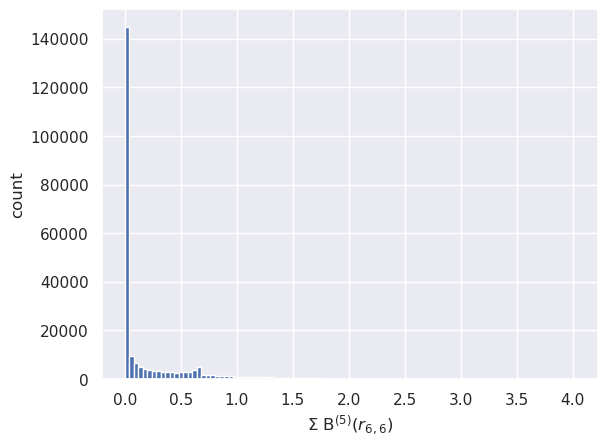

In [19]:
df[f"sum(B(r_{z_i}_{z_j}))"].apply(lambda x: x[basis_function]).hist(bins=100)
plt.xlabel(f"$\\Sigma$ B$^{{({basis_function})}}$($r_{{{z_i},{z_j}}}$)")
plt.ylabel("count")
plt.show()

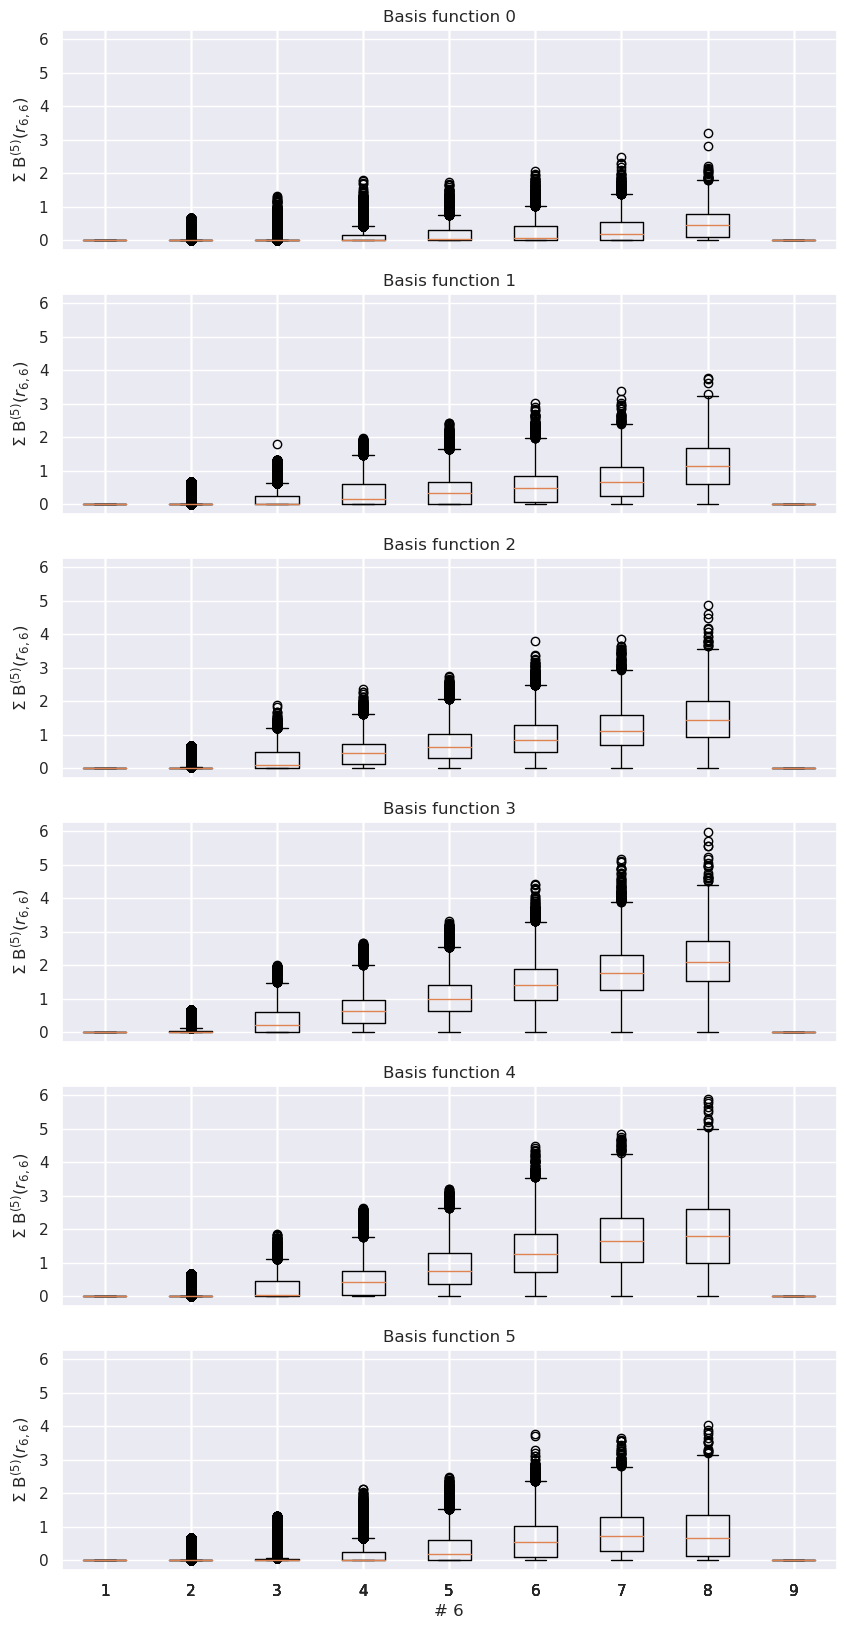

In [20]:
def collect_groupby(df, groupby, values):
    return [values[df[groupby] == g].values for g in df[groupby].unique()]

fig, axes = plt.subplots(N_KNOTS - 3 - 1, 1, figsize=(10, 20), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    ax.boxplot(collect_groupby(df, f"N_{z_i}", df[f"sum(B(r_{z_i}_{z_j}))"].apply(lambda x: x[i])))
    ax.set_title(f"Basis function {i}")
    ax.set_ylabel(f"$\\Sigma$ B$^{{({basis_function})}}$($r_{{{z_i},{z_j}}}$)")
plt.xlabel(f"# {z_i}")
plt.show()

In [21]:
df.query("N_1 == 2 and N_6 >= 1")

,mol,iconf,atomic_numbers,coordinates,pairs,pdist,r_1_1,r_1_6,r_1_7,r_1_8,...,N_within_r_1_1,N_within_r_1_6,N_within_r_1_7,N_within_r_1_8,N_within_r_6_6,N_within_r_6_7,N_within_r_6_8,N_within_r_7_7,N_within_r_7_8,N_within_r_8_8
1436,C1H2N2,0,"[6, 1, 1, 7, 7]","[[-0.003055805, -0.030419262, 0.05139095], [1....","[(1, 6), (1, 6), (6, 7), (6, 7), (1, 1), (1, 7...","[1.8672246706469535, 2.0442744053268593, 1.245...",[3.8417702],"[1.8672247, 2.0442743]","[1.1560113, 2.8878524, 3.2605093, 0.9800411]",[],...,0,0,2,0,0,2,0,0,0,0
1437,C1H2N2,1,"[6, 1, 1, 7, 7]","[[0.025158156, -0.06864563, -0.035694055], [1....","[(1, 6), (1, 6), (6, 7), (6, 7), (1, 1), (1, 7...","[1.9485985506513746, 2.1868444093810546, 1.192...",[4.0616164],"[1.9485985, 2.1868443]","[0.995524, 3.0686364, 3.366869, 1.0243025]",[],...,0,0,2,0,0,2,0,0,0,0
1438,C1H2N2,2,"[6, 1, 1, 7, 7]","[[-0.037765197, -0.01261671, -0.037668448], [-...","[(1, 6), (1, 6), (6, 7), (6, 7), (1, 1), (1, 7...","[2.178112759948494, 2.0175276993989892, 1.1067...",[4.1533318],"[2.1781127, 2.0175276]","[1.1507438, 3.4112425, 3.0321705, 1.0974189]",[],...,0,0,2,0,0,2,0,0,0,0
1439,C1H2N2,3,"[6, 1, 1, 7, 7]","[[-0.002880196, -0.010604168, 0.045451522], [1...","[(1, 6), (1, 6), (6, 7), (6, 7), (1, 1), (1, 7...","[1.8502075484112126, 2.062564185011617, 1.2312...",[3.8555505],"[1.8502076, 2.0625641]","[1.0958004, 2.8944232, 3.2666411, 0.9859729]",[],...,0,0,2,0,0,2,0,0,0,0
1440,C1H2N2,4,"[6, 1, 1, 7, 7]","[[-0.0070134946, -0.017933339, -0.034655783], ...","[(1, 6), (1, 6), (6, 7), (6, 7), (1, 1), (1, 7...","[1.9735661756212524, 2.18597562762268, 1.25308...",[4.110588],"[1.9735662, 2.1859756]","[1.0546333, 3.1071465, 3.4139273, 1.0276339]",[],...,0,0,2,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227402,C8H2,0,"[6, 6, 6, 6, 6, 6, 6, 6, 1, 1]","[[4.402144, 0.5119653, 0.11370172], [3.1739, -...","[(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6...","[1.3896790665802023, 2.6454072067118117, 3.843...",[10.880678],"[1.1672131, 9.8776045, 2.5290387, 8.671373, 3....",[],[],...,0,2,0,0,7,0,0,0,0,0
227403,C8H2,1,"[6, 6, 6, 6, 6, 6, 6, 6, 1, 1]","[[-4.520768, 0.49467716, 0.036591176], [-3.300...","[(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6...","[1.397003580331503, 2.8073298040428174, 3.8938...",[11.433147],"[1.3829259, 10.245954, 2.756325, 9.02766, 4.14...",[],[],...,0,2,0,0,7,0,0,0,0,0
227404,C8H2,2,"[6, 6, 6, 6, 6, 6, 6, 6, 1, 1]","[[-4.5090914, -0.06016159, 0.014842001], [-3.3...","[(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6...","[1.207057100433629, 2.6289181196437146, 3.8391...",[11.185312],"[1.0834332, 10.105187, 2.2868967, 8.899388, 3....",[],[],...,0,2,0,0,7,0,0,0,0,0
227405,C8H2,3,"[6, 6, 6, 6, 6, 6, 6, 6, 1, 1]","[[-4.503917, -0.3421017, -0.000250075], [-3.27...","[(6, 6), (6, 6), (6, 6), (6, 6), (6, 6), (6, 6...","[1.2838693516258886, 2.7057670801779286, 3.824...",[11.473287],"[1.2266014, 10.292377, 2.4954176, 9.048904, 3....",[],[],...,0,2,0,0,7,0,0,0,0,0
